In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
with open("./datasets/4_2_24/config.pkl", "rb") as handle:
    config = pickle.load(handle)
config

SyntheticVideoDatasetConfig(trajectory_factory=functools.partial(<function random_plane_2_trajectory_factory at 0x0000025BB0EDAFC0>, RandomPlane2Trajectory(seconds_per_point=1.0, num_points=5, spread=3.0)), scene=SyntheticSceneConfig(scene_factory=functools.partial(<function block_scene_factory at 0x0000025BB0EDB420>, config=BlockSceneConfig(blocks_per_face=7)), seed=587452, camera_fov=70, resolution=(128, 128)), num_videos=20, frames_per_video=5, frame_delta_time=1.0, save_dir='./datasets/4_2_24', regenerate_frequency=1)

In [20]:
frames: np.ndarray = np.load("./datasets/4_2_24/frames.npy")
frames.dtype

dtype('uint8')

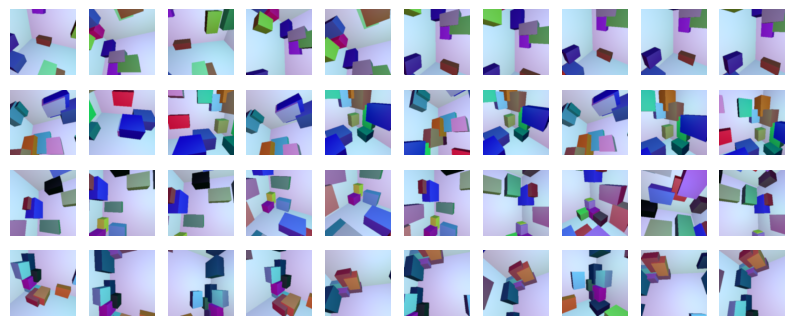

In [22]:
fig, ax = plt.subplots(nrows=4, ncols=10)
fig.set_size_inches(10, 4)
for j in range(4):
    for i in range(10):
        ax[j, i].axis('off')
        ax[j, i].imshow(frames[j, i])

In [5]:
import torch
from src.utils import compose
from functools import partial

train_x: torch.Tensor = compose(
    lambda x: x / 255.0,
    partial(torch.permute, dims=(0, 3, 1, 2)),
    partial(torch.squeeze, dim=1),
    torch.Tensor.float,
    torch.from_numpy
)(frames[:, 0])

In [16]:
from torchvision.transforms import GaussianBlur
gaussian_blur = GaussianBlur(kernel_size=15, sigma=5.5)

def loss_weight_curve(x: torch.Tensor):
    return 1.0 - torch.exp(-x)

@torch.no_grad()
def compute_loss_weight(imgs: torch.Tensor):
    """
    Compute a per-pixel loss weighting.
    
    imgs is a (N, 3, H, W) tensor
    returns a (N, 3, H, W) tensor
                    
    """
    
    zeros_column = torch.zeros_like(imgs)[:, :, :, 0:1]
    
    diff_x = torch.diff(imgs, dim=-1)
    diff_x = torch.concat([
        diff_x,
        zeros_column
    ], dim=-1)
    
    diff_y = torch.diff(imgs, dim=-2)
    diff_y = torch.concat([
        diff_y,
        zeros_column.transpose(-1, -2)
    ], dim=-2)
    
    diff_x = gaussian_blur.forward(diff_x)
    diff_y = gaussian_blur.forward(diff_y)
    
    diff = torch.sqrt(torch.square(diff_x) + torch.square(diff_y))

    return loss_weight_curve(2.0 * diff)

In [17]:
loss_weight = compute_loss_weight(train_x)

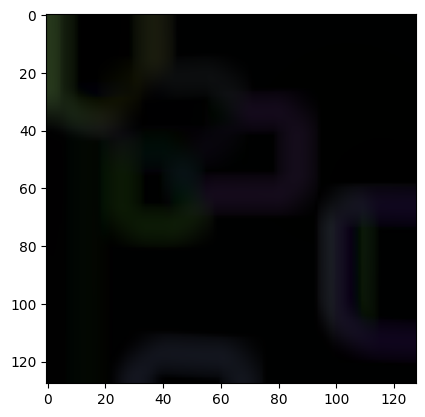

In [18]:
plt.imshow(loss_weight[0].permute(1, 2, 0))